In [104]:
# dependence for whole notebook

import numpy as np
import pandas
import os
import glob
import pandas as pd
from sound_classification import classification_service
from sklearn.metrics import confusion_matrix
import sklearn.calibration
import random
from sklearn.cross_validation import StratifiedKFold
import seaborn as sns
import sound_classification.confusion_matrix
random.seed = 0

%matplotlib notebook

In [2]:
b=89

In [3]:
from tests.test_bell_detection import _get_training_data

dataset_path = _get_training_data()  # dowloading dataset from dropbox
file_regexp = os.path.join(dataset_path, '*.wav')
files = glob.glob(file_regexp)

In [4]:
_class = [os.path.basename(f).split('-')[0] for f in files]
df = pd.DataFrame(zip(_class, files), columns=['classname', 'filename'])

df = df[~df.filename.str.contains('Romeo')]  # we remove file recorded on romeo from the database.. because there are in 44100Hz not 48000

print(df.classname.value_counts())

TacTac         51
Whistle        42
DeskBell       41
FireAlarmFr    32
DoorBell01     23
DoorBell02     22
Applause       16
dtype: int64


In [5]:
from sklearn.cross_validation import StratifiedKFold
n_folds = 3
stratified_fold = StratifiedKFold(df.classname, n_folds)  # we use only 3 fold.. as we have only 16 values on some data

folds = list(stratified_fold)

In [5]:
reload(classification_service)
def get_expected_predicted_stratified_fold(stratified_fold, df, window_block=None, clf=None, window_block_learning=None):    
    """ 
    Tool function to report classification accuracy for our classification tools
    """
    predicted=[]
    expected=[]
    filenames = []
    
    fold_num = 0
    for train_set, test_set in stratified_fold:
        train_files = df.iloc[train_set].filename
        sound_classification_obj = classification_service.SoundClassification(train_files.tolist(), clf=clf, window_block_learning=window_block_learning )
        sound_classification_obj.learn()
        labels = sound_classification_obj.clf.classes_
        for index in test_set:
            val = df.iloc[index]
            try:
                prediction = sound_classification_obj.processed_wav(val.filename, window_block=window_block, ignore_fs=True)
                expected.extend([val.classname]*len(prediction))
                predicted.extend(prediction)
                filenames.extend(['_'.join([val.filename, '_fold%s' % fold_num])]*len(prediction))  # we append the num of fold to filename to have easy difference after that.... TODO: use another column
            except classification_service.SoundClassificationException as e: 
                print("Exception %s detected on %s" % (e, val.filename))
        fold_num += 1
    return expected, predicted, labels, filenames   # ca commence a faire beaucoup, pourquoi ne pas renvoyer un dictionnaire, ou un pandas DataFrame: TODO

def print_report(expected, predicted_class, labels):
    # compute confusion matrix
    matrix = confusion_matrix(expected, predicted_class, labels=labels)
    print(matrix)

    # plot confusion matrix
    sound_classification.confusion_matrix.displayConfusionMatrix(matrix, labels=labels)
    
    # print report
    import sklearn
    print(sklearn.metrics.classification_report(expected, predicted_class))

# old version window window_learning_block to 1.0

CLF is SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
CLF is SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
CLF is SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
[[ 63   0   0   0   0   1   0]
 [  0  68   7   0   0  48   1]
 [  0   0  68   0   3  13   0]
 [  0   0   0  22   0  91  29]
 [  0   0   0   0 177   0   3]
 [  0   0   0   0   0  50   1]
 [  0   0   0   0   0   0  44]]


/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2499: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


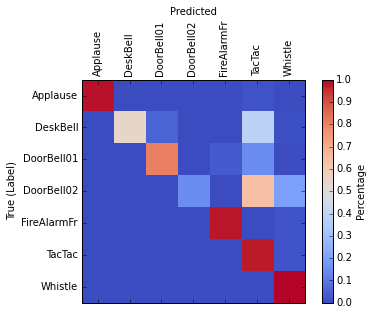

             precision    recall  f1-score   support

   Applause       1.00      0.98      0.99        64
   DeskBell       1.00      0.55      0.71       124
 DoorBell01       0.91      0.81      0.86        84
 DoorBell02       1.00      0.15      0.27       142
FireAlarmFr       0.98      0.98      0.98       180
     TacTac       0.25      0.98      0.39        51
    Whistle       0.56      1.00      0.72        44

avg / total       0.90      0.71      0.71       689



In [7]:
expected, predicted, labels, filenames = get_expected_predicted_stratified_fold(stratified_fold, df, window_block=1.0)
predicted_class = [x.class_predicted for x in predicted]
print_report(expected, predicted_class, labels)

# new version with window learning block to 1.0

CLF is SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
CLF is SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
CLF is SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
[[ 64   0   0   0   0   0   0]
 [  0 115   2   0   0   6   1]
 [  0   4  68   0   4   8   0]
 [  0   6   0  51   0  60  25]
 [  0   0   0   0 173   2   5]
 [  0   0   0   0   0  51   0]
 [  0   0   0   0   0   3  41]]


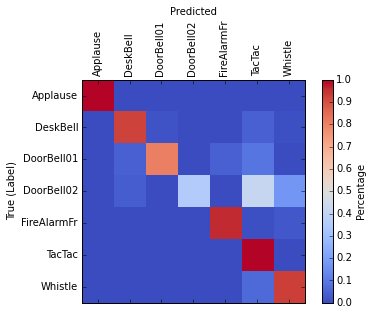

             precision    recall  f1-score   support

   Applause       1.00      1.00      1.00        64
   DeskBell       0.92      0.93      0.92       124
 DoorBell01       0.97      0.81      0.88        84
 DoorBell02       1.00      0.36      0.53       142
FireAlarmFr       0.98      0.96      0.97       180
     TacTac       0.39      1.00      0.56        51
    Whistle       0.57      0.93      0.71        44

avg / total       0.90      0.82      0.82       689



In [8]:
expected, predicted, labels, filenames = get_expected_predicted_stratified_fold(stratified_fold, df, window_block=1.0, window_block_learning=1.0)
predicted_class = [x.class_predicted for x in predicted]
print_report(expected, predicted_class, labels)

In [9]:
labels

array(['Applause', 'DeskBell', 'DoorBell01', 'DoorBell02', 'FireAlarmFr',
       'TacTac', 'Whistle'], dtype=object)

In [10]:
from sklearn.multiclass import OneVsRestClassifier
classif = OneVsRestClassifier(sklearn.svm.SVC(kernel='rbf', probability=True, verbose=False))
expected, predicted, labels, filenames = get_expected_predicted_stratified_fold(stratified_fold, df, window_block=1.5, window_block_learning=1.5, clf=classif)
#labels = labels.tolist()
labels = labels.tolist()
print_report(expected, predicted_class, labels)

CLF is OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
          n_jobs=1)
CLF is OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
          n_jobs=1)
CLF is OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
          n_jobs=1)


ValueError: Found arrays with inconsistent numbers of samples: [442 689]

In [ ]:
print(len(expected))
print(len(predicted_class))

In [ ]:
print_report(expected, predicted_class, labels)

# Compute threshold per class

we propose to return a threshold that provide a good precision.. for instance the user could specify a minimum precision and we return a threshold per class so this precision is respected.




In [ ]:
from sound_classification.evaluate_classification import plot_distribution_true_false

In [ ]:
%pylab inline
prediction_df = pd.DataFrame([[x.confidence, x.class_predicted, x.timestamp_start, expected_val, filename] for x, expected_val, filename in zip(predicted, expected, filenames)], columns=['confidence', 'class_predicted', 'timestamp_start', 'expected', 'filename'])
plot_distribution_true_false(prediction_df)

In [ ]:
pl

# computing "precision" cumulative curve..

I don't know if it's exist in litterature.. (and I feel it's wrong to create something new here.. I am sure someone as already done something similar/better')

Maybee it's similar to what is called "reliability curve?????" not sure, have to check the paper..TODO

In [ ]:
# Warning this methods are not optimal at all.. the complexity is high.. but we don't really care here..


def compute_precision_cumulative_curve(prediction_df, true_positive_class=None, step=0.01):
    mask_true = prediction_df.expected == prediction_df.class_predicted  # TRUE POSITIVE
    mask_wrong = (prediction_df.class_predicted == true_positive_class) & (prediction_df.expected != true_positive_class)  # FALSE POSITIVE
    bins = np.arange(0, 1, step)
    res = []
    for prediction_threshold in bins:
        false_cumulative = np.sum(prediction_df.confidence[mask_wrong] >= prediction_threshold)
        true_cumulative = np.sum(prediction_df.confidence[mask_true] >= prediction_threshold)
        precision_cumulative = true_cumulative / float(false_cumulative + true_cumulative)
        res.append(precision_cumulative)
    return bins, res

def plot_precision_cumulative_curve(prediction_df, true_positive_class=None, step=0.01):
    bins, res = compute_precision_cumulative_curve(prediction_df, true_positive_class=true_positive_class, step=step)
    pylab.scatter(bins, res)

    
def get_threshold_cum_precision(prediction_df, true_positive_class=None, min_expected_cum_precision=0.99):
    bins, precision_cumulative = compute_precision_cumulative_curve(prediction_df, true_positive_class=true_positive_class)
    valid_entry = np.argwhere(np.array(precision_cumulative) >= min_expected_cum_precision)
    if valid_entry == []:
        return 1  # worst threshold.. 
    else:
        return bins[valid_entry[0]] # first position
        
    

In [ ]:
%pylab inline
#plot_precision_cumulative_curve(prediction_df, true_positive_class='Whistle', step=0.01)
for class_name in set(prediction_df.expected):
    print class_name, get_threshold_cum_precision(prediction_df, true_positive_class=class_name, min_expected_cum_precision=1.0)


# TEST on new database

In [130]:
dataset_path = "/home/lgeorge/protolab_innov/data/sounds/dataset/"
file_regexp = os.path.join(dataset_path, '*/*.wav')
files = glob.glob(file_regexp)

_class = [os.path.basename(f).split('-')[0] for f in files]
df = pd.DataFrame(zip(_class, files), columns=['classname', 'filename'])

df = df[~df.filename.str.contains('Romeo')]  # we remove file recorded on romeo from the database.. because there are in 44100Hz not 48000

print(df.classname.value_counts())

n_folds = 3
stratified_fold = StratifiedKFold(df.classname, n_folds)  # we use only 3 fold.. as we have only 16 values on some data


# learning
expected, predicted, labels, filenames = get_expected_predicted_stratified_fold(stratified_fold, df, window_block=1.0)
predicted_class = [x.class_predicted for x in predicted]



ToyGiraffe          200
Whistle             111
ClapHand            103
ToyPig               96
ToyMaracas           65
FakeSneeze           52
TacTac               51
ShutDoor             48
DeskBell             41
HumanCaressHead      33
FireAlarmFr          32
DoorBell01           23
DoorBell02           22
HumanScratchHead     21
RobotNoiseMoving     19
ApplauseLight        16
NoisePaper           13
RobotNoisePushed      7
SmokeDetector         6
Laugh                 6
BlowNose              1
dtype: int64
CLF is SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
CLF is SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
CLF is SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel

Populating the interactive namespace from numpy and matplotlib
[[ 63   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0
    0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   3   0   0   0
    0   0   0]
 [  0   0  98   0   0   0   0   0   0   0   0   0   0   0   0   0   0   5
    0   0   0]
 [  0   0   2  68   1   0   0   0   0   0   0   0   2   0   0   0  32   2
    0   1   0]
 [  0   0   0   0  52   0   0   0   0   0   0   0   1   0   1   0   0   4
    0   0   1]
 [  0   0   0   0   0  11   0   0   0   0   0   0   0   0   0   0   2  79
    0  39   1]
 [  0   0   0   0   0   0  52   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [  0   0   0   0   0   0   0 164   0   0   0   0   0   0   0   0   0   5
    0   0   0]
 [  0   0   0   0   0   0   0   0  33   2   0   0   0   0   2   0   0   1
    0   0   0]
 [  0   0   0   0   0   0   0   0   3  16   0   0   0   0   0   0   0   1
    0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  

`%matplotlib` prevents importing * from pylab and numpy


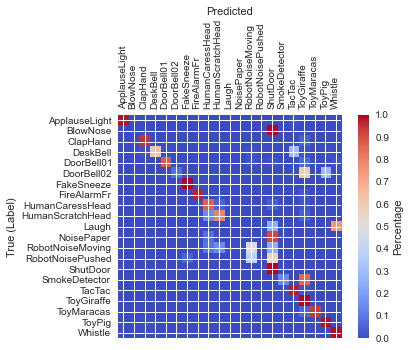

             precision    recall  f1-score   support

ApplauseLight       1.00      0.98      0.99        64
   BlowNose       0.00      0.00      0.00         3
   ClapHand       0.96      0.95      0.96       103
   DeskBell       1.00      0.63      0.77       108
 DoorBell01       0.98      0.88      0.93        59
 DoorBell02       1.00      0.08      0.15       132
 FakeSneeze       0.98      1.00      0.99        52
FireAlarmFr       1.00      0.97      0.98       169
HumanCaressHead       0.85      0.87      0.86        38
HumanScratchHead       0.76      0.80      0.78        20
      Laugh       0.00      0.00      0.00         4
 NoisePaper       0.00      0.00      0.00        12
RobotNoiseMoving       0.50      0.50      0.50        20
RobotNoisePushed       0.00      0.00      0.00        18
   ShutDoor       0.59      1.00      0.74        48
SmokeDetector       1.00      0.14      0.25         7
     TacTac       0.59      0.98      0.74        51
 ToyGiraffe       0.65

In [131]:
%pylab inline
print_report(expected, predicted_class, labels)

In [132]:


prediction_df = pd.DataFrame([[x.confidence, x.class_predicted, x.timestamp_start, expected_val, filename] for x, expected_val, filename in zip(predicted, expected, filenames)], columns=['confidence', 'class_predicted', 'timestamp_start', 'expected', 'filename'])

from sound_classification.evaluate_classification import *
threshold_dict = {}
for class_name in set(prediction_df.expected):
    threshold_dict[class_name] = get_threshold_cum_precision(prediction_df, true_positive_class=class_name, min_expected_cum_precision=0.995)
    print("%s : %s" % (class_name, threshold_dict[class_name] ))
print(threshold_dict)


DoorBell01 : 0.0
ShutDoor : 0.51
FireAlarmFr : 0.0
ApplauseLight : 0.0
NoisePaper : 0.0
ToyGiraffe : 0.68
ClapHand : 0.0
ToyPig : 0.69
SmokeDetector : 0.0
HumanScratchHead : 0.0
TacTac : 0.49
HumanCaressHead : 0.0
RobotNoiseMoving : 0.26
Whistle : 0.0
DoorBell02 : 0.0
DeskBell : 0.0
BlowNose : 0.0
Laugh : 0.0
RobotNoisePushed : 0.0
ToyMaracas : 0.0
FakeSneeze : 0.0
{'FakeSneeze': 0.0, 'RobotNoiseMoving': 0.26000000000000001, 'ShutDoor': 0.51000000000000001, 'FireAlarmFr': 0.0, 'ApplauseLight': 0.0, 'NoisePaper': 0.0, 'ClapHand': 0.0, 'ToyPig': 0.69000000000000006, 'SmokeDetector': 0.0, 'HumanScratchHead': 0.0, 'TacTac': 0.48999999999999999, 'HumanCaressHead': 0.0, 'DoorBell01': 0.0, 'Whistle': 0.0, 'DoorBell02': 0.0, 'DeskBell': 0.0, 'BlowNose': 0.0, 'Laugh': 0.0, 'RobotNoisePushed': 0.0, 'ToyMaracas': 0.0, 'ToyGiraffe': 0.68000000000000005}


In [ ]:
filtered_prediction_df.head()

Populating the interactive namespace from numpy and matplotlib
group_name ApplauseLight
x must have at least one data point
FIN figure ApplauseLight


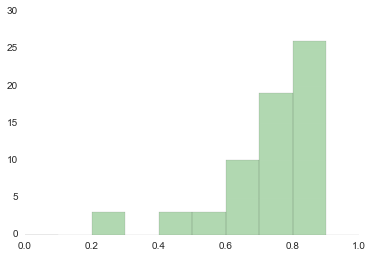


group_name BlowNose
x must have at least one data point
x must have at least one data point
FIN figure BlowNose


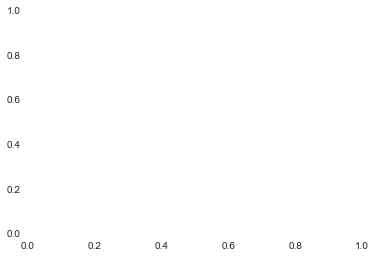


group_name ClapHand
FIN figure ClapHand


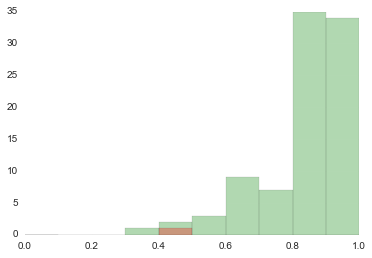


group_name DeskBell
FIN figure DeskBell


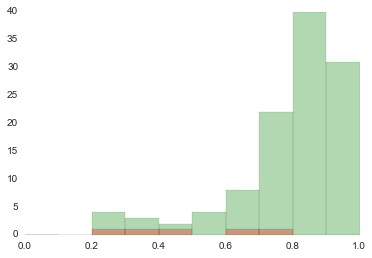


group_name DoorBell01
FIN figure DoorBell01


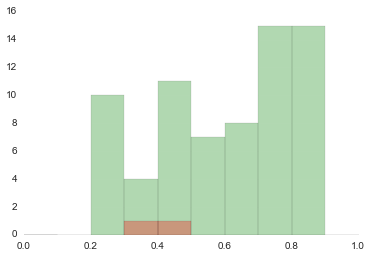


group_name DoorBell02
x must have at least one data point
FIN figure DoorBell02


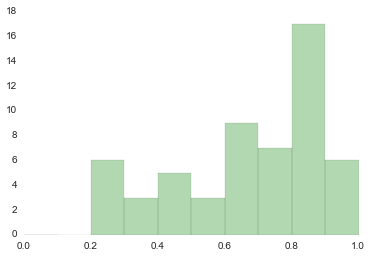


group_name FakeSneeze
x must have at least one data point
FIN figure FakeSneeze


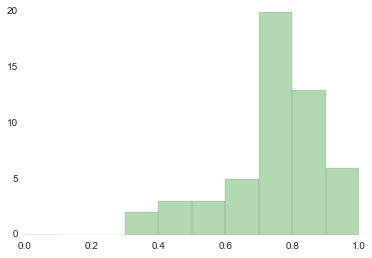


group_name FireAlarmFr
x must have at least one data point
FIN figure FireAlarmFr


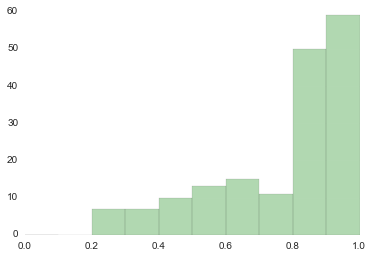


group_name HumanCaressHead
FIN figure HumanCaressHead


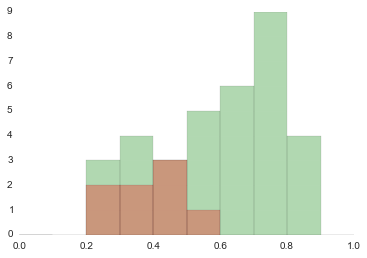


group_name HumanScratchHead
FIN figure HumanScratchHead


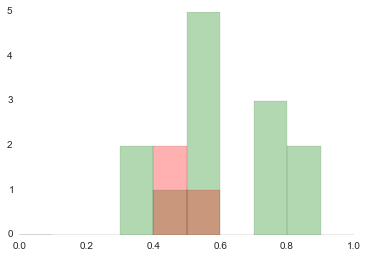


group_name Laugh
x must have at least one data point
x must have at least one data point
FIN figure Laugh


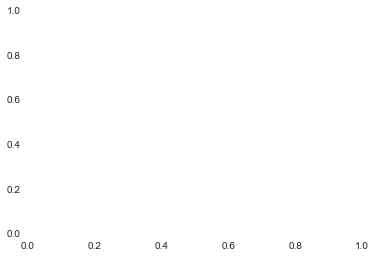


group_name NoisePaper
x must have at least one data point
x must have at least one data point
FIN figure NoisePaper


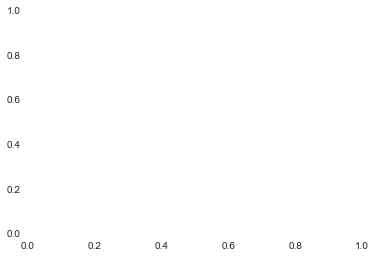


group_name RobotNoiseMoving
FIN figure RobotNoiseMoving


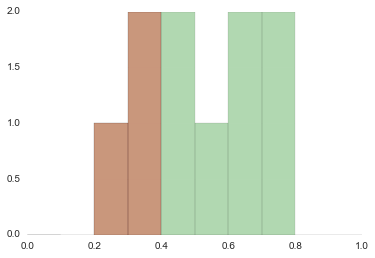


group_name RobotNoisePushed
FIN figure RobotNoisePushed


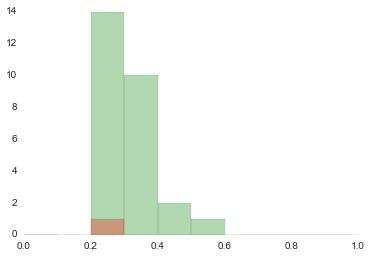


group_name ShutDoor
FIN figure ShutDoor


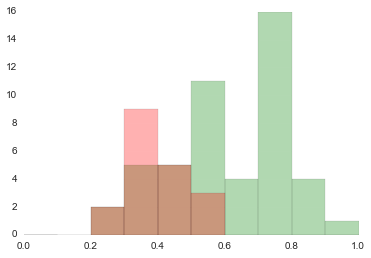


group_name SmokeDetector
x must have at least one data point
x must have at least one data point
FIN figure SmokeDetector


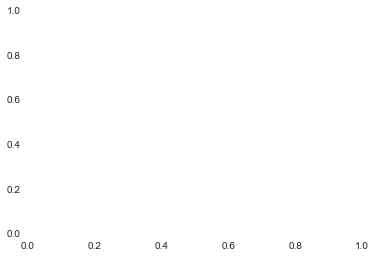


group_name TacTac
FIN figure TacTac


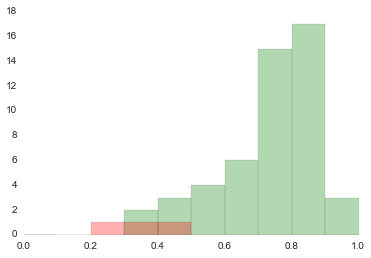


group_name ToyGiraffe
FIN figure ToyGiraffe


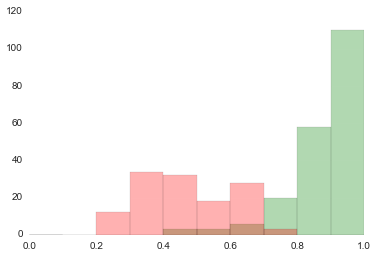


group_name ToyMaracas
x must have at least one data point
FIN figure ToyMaracas


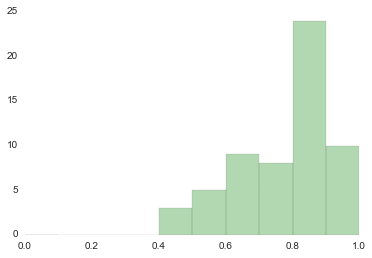


group_name ToyPig
FIN figure ToyPig


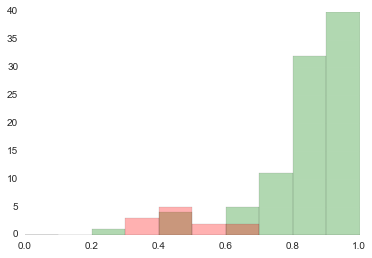


group_name Whistle
FIN figure Whistle


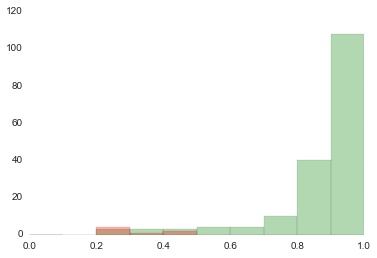

In [88]:
%pylab inline
import sound_classification.evaluate_classification
reload(sound_classification.evaluate_classification)
sound_classification.evaluate_classification.plot_distribution_true_false(prediction_df)

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


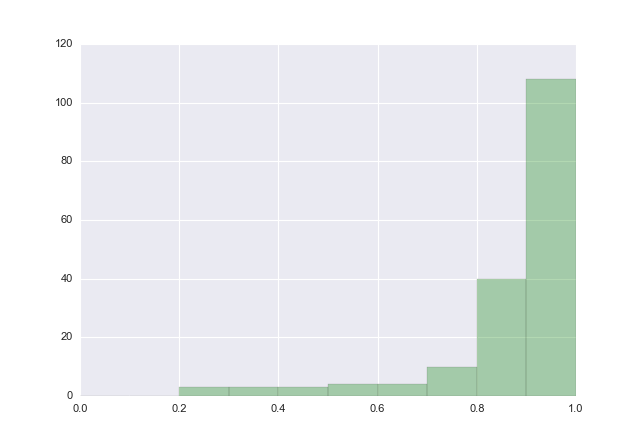

In [87]:
%pylab qt
pylab.figure()
pylab.hist(list(g.confidence[maskTrue]), color='g', alpha=0.3, normed=0, range=(0,1), bins=10)
pylab.show()

## NORMALIZATION ALEX


In [97]:
threshold_dict


{'ApplauseLight': 0.0,
 'BlowNose': 0.0,
 'ClapHand': 0.40000000000000002,
 'DeskBell': 0.0,
 'DoorBell01': 0.20999999999999999,
 'DoorBell02': 0.0,
 'FakeSneeze': 0.34000000000000002,
 'FireAlarmFr': 0.0,
 'HumanCaressHead': 0.48999999999999999,
 'HumanScratchHead': 0.53000000000000003,
 'Laugh': 0.0,
 'NoisePaper': 0.0,
 'RobotNoiseMoving': 0.35000000000000003,
 'RobotNoisePushed': 0.0,
 'ShutDoor': 0.57000000000000006,
 'SmokeDetector': 0.0,
 'TacTac': 0.56000000000000005,
 'ToyGiraffe': 0.71999999999999997,
 'ToyMaracas': 0.0,
 'ToyPig': 0.70000000000000007,
 'Whistle': 0.34000000000000002}

In [99]:
res = {}

for name, val in threshold_dict.iteritems():
    res[name] = 0.9 / val
res

{'ApplauseLight': inf,
 'BlowNose': inf,
 'ClapHand': 2.25,
 'DeskBell': inf,
 'DoorBell01': 4.2857142857142856,
 'DoorBell02': inf,
 'FakeSneeze': 2.6470588235294117,
 'FireAlarmFr': inf,
 'HumanCaressHead': 1.8367346938775511,
 'HumanScratchHead': 1.6981132075471699,
 'Laugh': inf,
 'NoisePaper': inf,
 'RobotNoiseMoving': 2.5714285714285712,
 'RobotNoisePushed': inf,
 'ShutDoor': 1.5789473684210524,
 'SmokeDetector': inf,
 'TacTac': 1.607142857142857,
 'ToyGiraffe': 1.25,
 'ToyMaracas': inf,
 'ToyPig': 1.2857142857142856,
 'Whistle': 2.6470588235294117}

In [133]:
import sound_classification.evaluate_classification
reload(sound_classification.evaluate_classification)

def filter_out_based_on_threshold(prediction_df, score_threshold_dict):
    # we use threshold_dict to filter out value with confidence bellow threshold and assigned class UNKNOWN
    for name, threshold in score_threshold_dict.iteritems():
        #print name, threshold[0]
        #print((prediction_df.class_predicted == name).shape)
        #print((prediction_df.confidence < threshold).shape)
        mask = (prediction_df.class_predicted == name) & (prediction_df.confidence < threshold)
        prediction_df.class_predicted[mask] = 'UNKNOWN'
    return prediction_df

filtered_prediction_df = filter_out_based_on_threshold(prediction_df.copy(), threshold_dict)
new_labels = np.concatenate([labels,  ['UNKNOWN']])


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Populating the interactive namespace from numpy and matplotlib
[[ 63   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   1]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   3   0   0   0
    0   0   0   0]
 [  0   0  98   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   5]
 [  0   0   2  68   1   0   0   0   0   0   0   0   2   0   0   0   3   0
    0   0   0  32]
 [  0   0   0   0  52   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   1   6]
 [  0   0   0   0   0  11   0   0   0   0   0   0   0   0   0   0   0   1
    0   3   1 116]
 [  0   0   0   0   0   0  52   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   0   0   0 164   0   0   0   0   0   0   0   0   0   0
    0   0   0   5]
 [  0   0   0   0   0   0   0   0  33   2   0   0   0   0   0   0   0   0
    0   0   0   3]
 [  0   0   0   0   0   0   0   0   3  16   0   0   0   0   0   0   0   0
    0   0   0   1]
 [  0  

`%matplotlib` prevents importing * from pylab and numpy


<IPython.core.display.Javascript object>


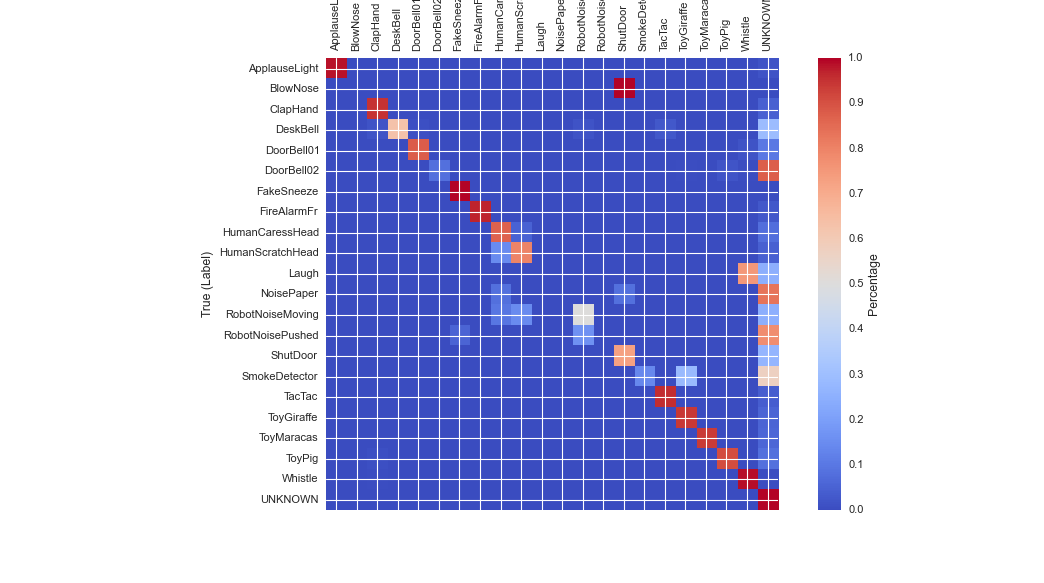

             precision    recall  f1-score   support

ApplauseLight       1.00      0.98      0.99        64
   BlowNose       0.00      0.00      0.00         3
   ClapHand       0.96      0.95      0.96       103
   DeskBell       1.00      0.63      0.77       108
 DoorBell01       0.98      0.88      0.93        59
 DoorBell02       1.00      0.08      0.15       132
 FakeSneeze       0.98      1.00      0.99        52
FireAlarmFr       1.00      0.97      0.98       169
HumanCaressHead       0.85      0.87      0.86        38
HumanScratchHead       0.76      0.80      0.78        20
      Laugh       0.00      0.00      0.00         4
 NoisePaper       0.00      0.00      0.00        12
RobotNoiseMoving       0.67      0.50      0.57        20
RobotNoisePushed       0.00      0.00      0.00        18
   ShutDoor       0.90      0.73      0.80        48
SmokeDetector       1.00      0.14      0.25         7
     TacTac       0.94      0.96      0.95        51
 ToyGiraffe       0.98

In [134]:
%pylab notebook
sound_classification.evaluate_classification.print_report(list(filtered_prediction_df.expected) + ['UNKNOWN'], list(filtered_prediction_df.class_predicted) + ['UNKNOWN'], new_labels  )
